In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [33]:
# load train data
data = pd.read_csv('data/train_cleaned.csv', keep_default_na=False)
X, y = data.drop('Transported', axis=1), data['Transported']

# split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 17), (1739, 17), (6954,), (1739,))

In [58]:
# Identify the numerical and categorical columns
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Remove 'FirstName', 'LastName', and 'Fullname' from the categorical columns
cat_cols = [col for col in cat_cols if col not in ['FirstName', 'LastName']]

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ])

# Define the model
model = XGBClassifier(random_state=42, eval_metric='logloss')

# Bundle preprocessing and modeling code in a pipeline
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Preprocess of training data, fit model 
xgb_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_xgb = xgb_clf.predict(X_val)

# Compute the classification report
report_xgb = classification_report(y_val, y_val_pred_xgb)
print('Classification Report: \n', report_xgb)

Accuracy:  0.7429557216791259
Classification Report: 
               precision    recall  f1-score   support

       False       0.70      0.83      0.76       863
        True       0.80      0.65      0.72       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [59]:
# Define the parameter grid
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    'model__n_estimators': [50, 100, 200, 300],
    'model__subsample': [0.5, 0.7, 1],
    'model__colsample_bytree': [0.5, 0.7, 1],
}

# Instantiate the grid search model
grid_search_xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_xgb_clf.fit(X_val, y_val)

# Get the best parameters
xgb_clf_best_params = grid_search_xgb_clf.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.5; total time=   0.1s
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.5; total time=   0.1s
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.5; total time=   0.1s
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.5; total time=   0.1s
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.7; total time=   0.1s
[CV] END model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.5; total time=   0.1s
[CV] END model__colsample_bytree=0.5

In [60]:
print('Best parameters found: ', xgb_clf_best_params)

# Fit the model with the best parameters
xgb_clf.set_params(**xgb_clf_best_params)
xgb_clf.fit(X_train, y_train)

# classification report
report_xgb = classification_report(y_val, y_val_pred_xgb)
print('Classification Report: \n', report_xgb)

Best parameters found:  {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__subsample': 1}
Accuracy:  0.7441058079355952
Classification Report: 
               precision    recall  f1-score   support

       False       0.70      0.84      0.77       863
        True       0.81      0.65      0.72       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



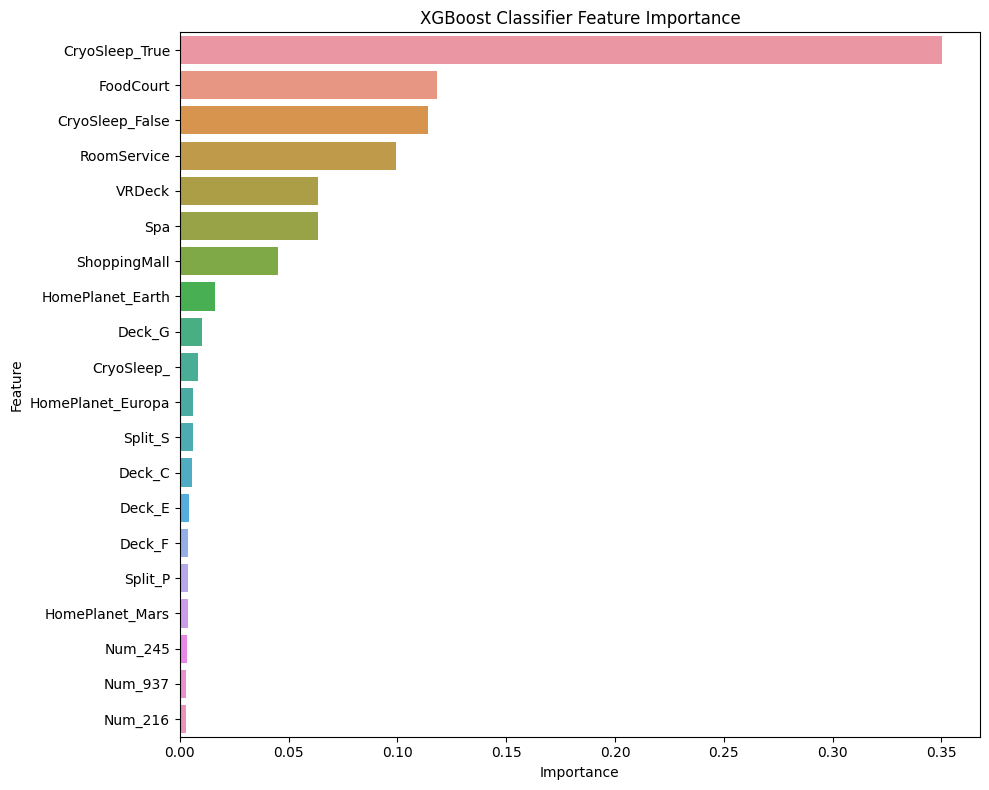

In [61]:
# Get the feature importance
importances = xgb_clf.named_steps['model'].feature_importances_

# Get feature names after one-hot encoding
onehot_columns = list(xgb_clf.named_steps['preprocessor'].transformers_[1][1]
   .named_steps['onehot'].get_feature_names_out(cat_cols))

# add the numeric column names
feature_names = num_cols + onehot_columns

# Create a dataframe of feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df[:20])
plt.title('XGBoost Classifier Feature Importance')
plt.tight_layout()
plt.show()

In [62]:
# Train a Random Forest Classifier

# Define the model
model = RandomForestClassifier(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model)])

# Preprocess of training data, fit model
rf_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_rf = rf_clf.predict(X_val)

# Compute the classification report
report_rf = classification_report(y_val, y_val_pred_rf)
print('Classification Report: \n', report_rf)

Accuracy:  0.7492811960897068
Classification Report: 
               precision    recall  f1-score   support

       False       0.71      0.83      0.77       863
        True       0.80      0.67      0.73       876

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739



In [63]:
# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# Instantiate the grid search model
grid_search_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=param_grid,           
                            cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf_clf.fit(X_val, y_val)

# Get the best parameters
rf_clf_best_params = grid_search_rf_clf.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.6s
[CV] END model__max_

In [64]:
print('Best parameters found: ', rf_clf_best_params)

# Fit the model with the best parameters
rf_clf.set_params(**rf_clf_best_params)

# accuracy on validation data
rf_clf.fit(X_train, y_train)

# classification report
report_rf = classification_report(y_val, y_val_pred_rf)
print('Classification Report: \n', report_rf)

Best parameters found:  {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Accuracy:  0.7446808510638298
Classification Report: 
               precision    recall  f1-score   support

       False       0.71      0.82      0.76       863
        True       0.79      0.67      0.73       876

    accuracy                           0.74      1739
   macro avg       0.75      0.75      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [46]:
# Train a Logistic Regression Classifier

# Define the model
model = LogisticRegression(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model)])

# Preprocess of training data, fit model
log_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_log = log_clf.predict(X_val)

# Compute the classification report
report_log = classification_report(y_val, y_val_pred_log)
print('Classification Report: \n', report_log)

Accuracy:  0.7107533064979874
Classification Report: 
               precision    recall  f1-score   support

       False       0.68      0.77      0.73       863
        True       0.74      0.65      0.69       876

    accuracy                           0.71      1739
   macro avg       0.71      0.71      0.71      1739
weighted avg       0.71      0.71      0.71      1739



/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Define the parameter grid
param_grid = {
    'model__C': np.logspace(-4, 4, 20),
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Instantiate the grid search model
grid_search_log_clf = GridSearchCV(estimator=log_clf, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search_log_clf.fit(X_val, y_val)

# Get the best parameters
log_clf_best_params = grid_search_log_clf.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/daniel/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

In [49]:
print('Best parameters found: ', log_clf_best_params)

# Fit the model with the best parameters
log_clf.set_params(**log_clf_best_params)

# accuracy on validation data
log_clf.fit(X_train, y_train)

y_val_pred_log = log_clf.predict(X_val)

# classification report
report_log = classification_report(y_val, y_val_pred_log)
print('Classification Report: \n', report_log)

Best parameters found:  {'model__C': 0.03359818286283781, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Accuracy:  0.7182288671650374
Classification Report: 
               precision    recall  f1-score   support

       False       0.68      0.80      0.74       863
        True       0.76      0.64      0.69       876

    accuracy                           0.72      1739
   macro avg       0.72      0.72      0.72      1739
weighted avg       0.72      0.72      0.72      1739



In [67]:
# Train a Support Vector Machine Classifier

# Define the model
model = SVC(random_state=42, probability=True)

# Bundle preprocessing and modeling code in a pipeline
svm_clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model)])

# Preprocess of training data, fit model
svm_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_svm = svm_clf.predict(X_val)

# Compute the classification report
report_svm = classification_report(y_val, y_val_pred_svm)
print('Classification Report: \n', report_svm)

Accuracy:  0.7377803335250144
Classification Report: 
               precision    recall  f1-score   support

       False       0.69      0.84      0.76       863
        True       0.80      0.64      0.71       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [68]:
# Define the parameter grid
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__kernel': ['rbf', 'linear']
}

# Instantiate the grid search model
grid_search_svm_clf = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search_svm_clf.fit(X_val, y_val)

# Get the best parameters
svm_clf_best_params = grid_search_svm_clf.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [69]:
print('Best parameters found: ', svm_clf_best_params)

# Fit the model with the best parameters
svm_clf.set_params(**svm_clf_best_params)

# accuracy on validation data
svm_clf.fit(X_train, y_train)

y_val_pred_svm = svm_clf.predict(X_val)

# classification report
report_svm = classification_report(y_val, y_val_pred_svm)
print('Classification Report: \n', report_svm)

Best parameters found:  {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Accuracy:  0.738355376653249
Classification Report: 
               precision    recall  f1-score   support

       False       0.70      0.83      0.76       863
        True       0.79      0.65      0.71       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [55]:
# Train a K-Nearest Neighbors Classifier

# Define the model
model = KNeighborsClassifier()

# Bundle preprocessing and modeling code in a pipeline
knn_clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model)])

# Preprocess of training data, fit model
knn_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_knn = knn_clf.predict(X_val)

# Compute the  classification report
report_knn = classification_report(y_val, y_val_pred_knn)
print('Classification Report: \n', report_knn)

Accuracy:  0.7153536515238643
Classification Report: 
               precision    recall  f1-score   support

       False       0.70      0.75      0.72       863
        True       0.74      0.68      0.71       876

    accuracy                           0.72      1739
   macro avg       0.72      0.72      0.72      1739
weighted avg       0.72      0.72      0.71      1739



In [56]:
# Define the parameter grid
param_grid = {
    'model__n_neighbors': list(range(1, 31)),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Instantiate the grid search model
grid_search_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search_knn_clf.fit(X_val, y_val)

# Get the best parameters
knn_clf_best_params = grid_search_knn_clf.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [57]:
print('Best parameters found: ', knn_clf_best_params)

# Fit the model with the best parameters
knn_clf.set_params(**knn_clf_best_params)

# accuracy on validation data
knn_clf.fit(X_train, y_train)

y_val_pred_knn = knn_clf.predict(X_val)
accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
print('Accuracy: ', accuracy_knn)

# classification report
report_knn = classification_report(y_val, y_val_pred_knn)
print('Classification Report: \n', report_knn)

Best parameters found:  {'model__metric': 'manhattan', 'model__n_neighbors': 6, 'model__weights': 'uniform'}
Accuracy:  0.7280046003450259
Classification Report: 
               precision    recall  f1-score   support

       False       0.68      0.84      0.75       863
        True       0.80      0.62      0.70       876

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.72      1739
weighted avg       0.74      0.73      0.72      1739



In [70]:
# Train a soft voting classifier using all the models

estimators = [('xgb', xgb_clf),
              ('rf', rf_clf),
                ('log', log_clf),
                ('svm', svm_clf),
                ('knn', knn_clf)]

# Instantiate the voting classifier
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the model on the training data
voting_clf.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_voting = voting_clf.predict(X_val)

# Compute the classification report
report_voting = classification_report(y_val, y_val_pred_voting)
print('Classification Report: \n', report_voting)

Accuracy:  0.7400805060379528
Classification Report: 
               precision    recall  f1-score   support

       False       0.70      0.82      0.76       863
        True       0.79      0.66      0.72       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [76]:
# Train a soft voting classifier using only xgboost and random forest

estimators = [('xgb', xgb_clf),
              ('rf', rf_clf)]
                
# Instantiate the voting classifier
voting_clf2 = VotingClassifier(estimators=estimators, voting='soft')

# Fit the model on the training data
voting_clf2.fit(X_train, y_train)

# Preprocess of validation data, get predictions
y_val_pred_voting = voting_clf2.predict(X_val)

# generate classification report
accuracy_voting = accuracy_score(y_val, y_val_pred_voting)
print('Accuracy: ', accuracy_voting)
report_voting = classification_report(y_val, y_val_pred_voting)
print('Classification Report: \n', report_voting)

Accuracy:  0.7492811960897068
Classification Report: 
               precision    recall  f1-score   support

       False       0.71      0.83      0.77       863
        True       0.80      0.67      0.73       876

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739



In [81]:
# predict on test data for Kaggle submission
test = pd.read_csv('data/test_cleaned.csv', keep_default_na=False)

# preprocess test data
X_test = test.drop(['PassengerId'], axis=1)

# Preprocess of test data, get predictions
y_test_pred_voting = voting_clf2.predict(X_test)

# create submission file
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': y_test_pred_voting})
submission.to_csv('data/submission.csv', index=False)

In [78]:
# save voting_clf2 model
filename = 'models/voting_clf2.pkl'
pickle.dump(voting_clf2, open(filename, 'wb'))